# Programming Assignment 2

## Random Forest Implementation for Classification Task

### Instructions

1. **Objective**:  
   Implement a Random Forest classifier for Classification Task in this notebook.

2. **File Naming and Submission**:  
   - Save the completed notebook as `<Roll_No>_P1.ipynb`, replacing `<Roll_No>` with your roll number.  
   - Ensure all code, outputs, and results are included in the submitted file.

3. **Code Placement**:  
   - Write your code **only** in the cells marked as `## CODE REQUIRED ##`.  
   - Place your implementation between the following comments:  
     ```python
     ### START CODE HERE ###
     # Your code along with comments goes here
     ### END CODE HERE ###
     ```
   - Do not modify any other sections of the notebook.
  

4. **Execution and Output**:  
   - Run all cells to ensure the code executes correctly without errors.  
   - Save the notebook **with all outputs visible** before submission.


## Random Forest Classifier

### Dataset Details

The dataset being used is the **Indians Diabetes Database**. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

#### Attributes:
1. **Pregnancies**: Number of times pregnant
2. **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. **BloodPressure**: Diastolic blood pressure (mm Hg)
4. **SkinThickness**: Triceps skin fold thickness (mm)
5. **Insulin**: 2-Hour serum insulin (mu U/ml)
6. **BMI**: Body mass index (weight in kg/(height in m)^2)
7. **DiabetesPedigreeFunction**: Diabetes pedigree function
8. **Age**: Age (years)
9. **Outcome** (class attribute, Target Variable): This is the target variable with the following categories:
   - 0: No diabetes
   - 1: Diabetes

You are required to use the exact CSV files (**dataset_train.csv and dataset_test.csv**) provided with this assignment for all analyses.


## Import necessary library functions

In [74]:
import numpy as np
from math import sqrt
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
from tqdm import tqdm
import pandas as pd


In [75]:
# Set the random seed for reproducibility.
# DO NOT modify this section, as it is essential for automated evaluation.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Instructions: Loading and Processing the Dataset

Follow these steps to load and process the dataset in Python:


### **Steps Performed in the Function**

- Step 1: Load the Dataset: Use the `pandas` library to load the dataset from the specified CSV file (`file_name`).


- Step 2: Separate Features and Target Variable: Split the dataset into:
  - **Features (`X`)**: A 2D array containing all columns except the target column
  - **Target (`y`)**: A 1D array containing the target (class label) column (0/1)

- Step 3: Return Processed Data: The function returns:

1. `X` should be of type `<class 'numpy.ndarray'>` and have shape `(num_samples, num_features)`.
2. `y` should be of type `<class 'numpy.ndarray'>` and have shape `(num_samples,)`.
3. `df` should be of type `<pandas.DataFrame>`



In [76]:
### CODE REQUIRED ###
def load_data(file_name):
  """
  This function loads the dataset from a CSV file and returns the features, target labels and dataframe

  Returns:
      X (ndarray): A 2D array of normalized features.
      y (ndarray): A 1D array of target values (class labels).
      df(pandas.DataFrame): The original DataFrame containing the dataset.
  """

  ### START CODE HERE ###
  df = pd.read_csv(file_name)
  X = df.iloc[:, :-1].values
  y = df.iloc[:, -1].values
  return X, y, df
  ### END CODE HERE ###

In [77]:
X_train, y_train, df_train = load_data('dataset_train.csv')

In [78]:
print(f"Dataset loaded: {X_train.shape[0]} samples, {X_train.shape[1]} features")
feature_names = df_train.columns[:-1]
print(f"Feature names: {', '.join(feature_names)}")

Dataset loaded: 614 samples, 8 features
Feature names: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age


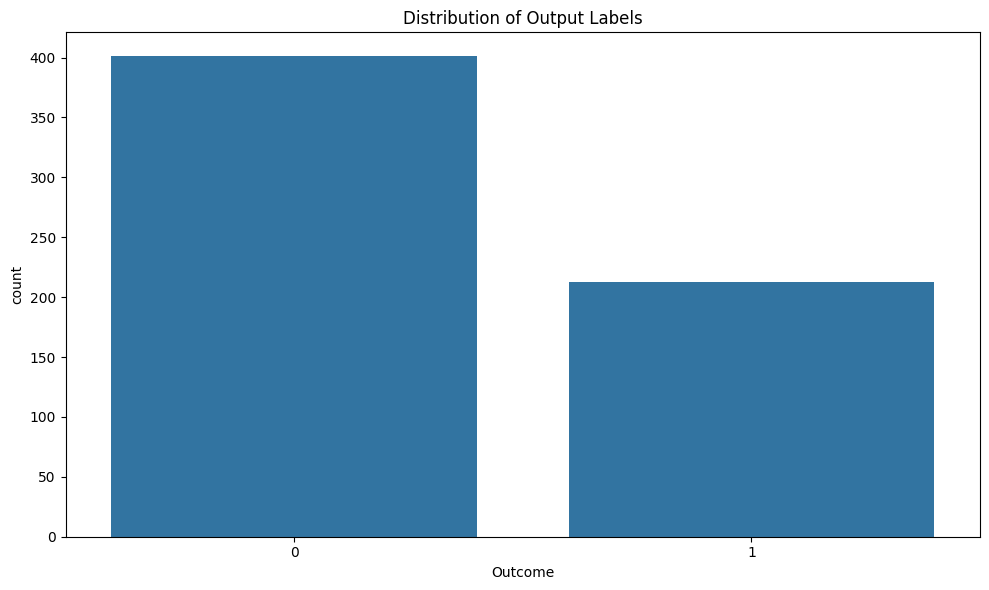

In [79]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='Outcome')
plt.title('Distribution of Output Labels')
plt.tight_layout()
plt.show()

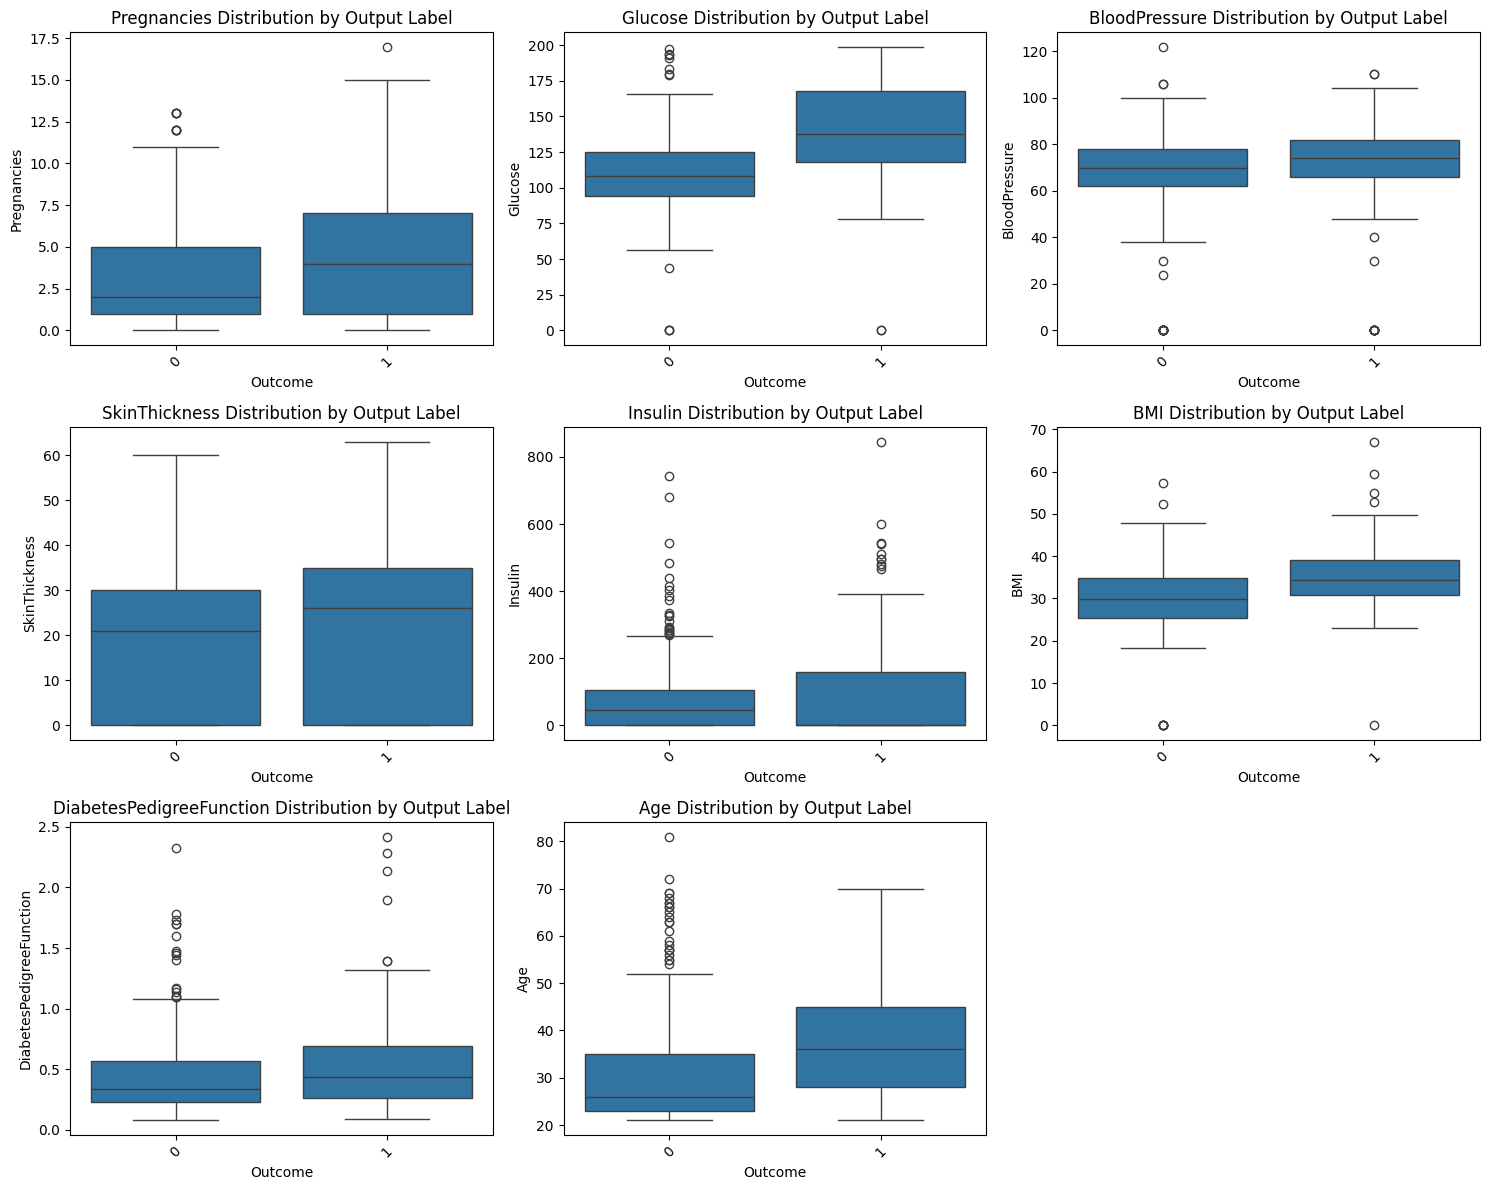

In [80]:
num_features = 8  # Updating the number of features
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Adjusting row count

plt.figure(figsize=(15, 4 * num_rows))

for i, feature in enumerate(feature_names):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df_train, x='Outcome', y=feature)
    plt.xticks(rotation=45)
    plt.title(f'{feature} Distribution by Output Label')

plt.tight_layout()
plt.show()

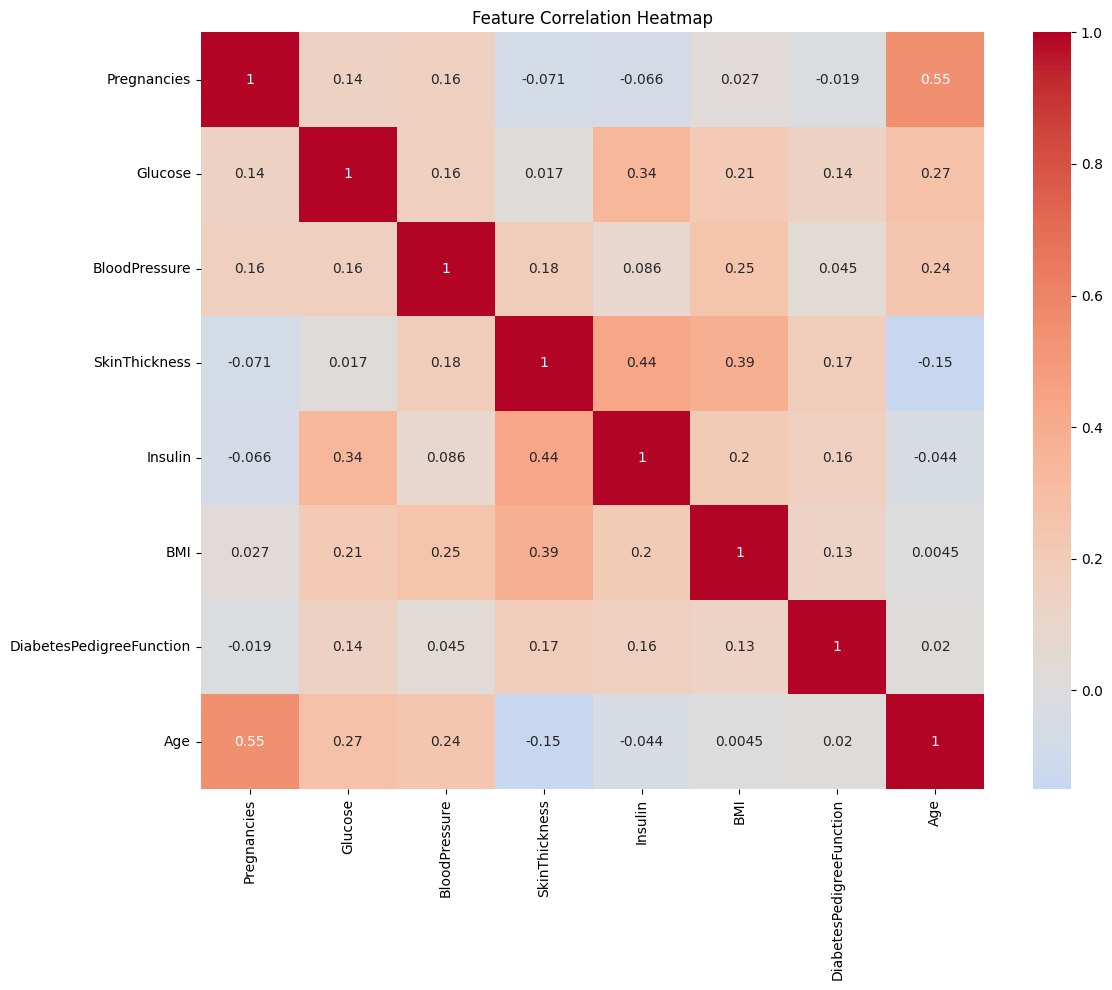

In [81]:
# Correlation heatmap
# This heatmap shows the correlation between different features in the dataset.
# It helps us understand how strongly the features are related to each other, with positive or negative correlations.

plt.figure(figsize=(12, 10))
sns.heatmap(df_train.drop('Outcome', axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [82]:
class Node:
  """
  This class represents a single node in a decision tree.
  It can either be a decision node (with a feature and threshold) or a leaf node (with a value).
  """

  def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
    """
    Initializes a new Node. It can represent either a decision node or a leaf node.

    Parameters:
        feature (int or None): The feature index for splitting at this node (None for leaf nodes).
        threshold (float or None): The threshold value for splitting (None for leaf nodes).
        left (Node or None): The left child node (None for leaf nodes).
        right (Node or None): The right child node (None for leaf nodes).
        value (int or None): The class label for leaf nodes, None for decision nodes.
    """
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf(self):
    """
    Determines whether the current node is a leaf node.

    Returns:
        bool: True if the node is a leaf (i.e., has a value), False otherwise.
    """
    return self.value is not None


### Step-by-Step Explanation for Decision Tree Ckass

### 1.**_grow_tree**:
This function is responsible for recursively growing a decision tree for classification using a custom Random Forest implementation. The tree-building process involves splitting the data based on the best feature and threshold at each step, using a metric called information gain.

##### a. **Input Parameters:**
- `X` : Feature matrix (input data)
- `y` : Labels (target values)
- `depth` : The current depth of the tree (used for stopping conditions)

##### b. **Stopping Criteria:**
   The recursion stops if any of the following conditions are met:
   - The current depth of the tree reaches the `self.max_depth`.
   - The number of samples in a node is less than `self.min_samples_split`.
   - There is only one unique label in the current node (that is all samples in X have the same label).
   
   If any of these criteria are met, a leaf node is created with the most common label from `y`.

##### c. **Feature Selection:**
   - Randomly select a subset of features (`feat_idxs`) from the total number of features.
   - This subset size is determined by `self.num_features` (the number of features used for splitting).

##### d. **Finding the Best Split:**
   - For each feature in the selected subset (`feat_idx`), do the following:
     - Get the values in the feature column (`X_column`).
     - Find all possible thresholds (unique values) for this feature.
     - For each threshold:
       - Split the data into two groups: left (`left_idxs`) and right (`right_idxs`), based on whether the feature value is less than the threshold or not.
       - If both the left and right groups have at least one sample, calculate the **information gain** by splitting the dataset at this threshold.
       - Keep track of the best threshold that gives the highest information gain.
    

##### e. **Create Leaf Node (if no valid split):**
   If no valid split is found (i.e., no feature gives a positive information gain), create a leaf node with the most common label in the target labels (`y`).

##### f. **Recursively Grow the Left and Right Subtrees:**
   - Recursively call the `_grow_tree` function to grow the left and right subtrees using the split data.
   - The left subtree is created using the data that satisfies `X_column < threshold`, and the right subtree is created using the data where `X_column >= threshold`.
   
   left = self._grow_tree(
            left_X,
            left_y,
            depth + 1
        )

##### g. **Return the Node:**
   - Once the left and right subtrees are created, return a node that represents the decision at this step in the tree, which contains:
     - The feature index used for the split (`feature`).
     - The threshold used for the split (`threshold`).
     - The left child subtree (type Node same as return type of _grow_tree) (`left`).
     - The right child subtree (type Node) (`right`).

### 2. **fit**:

a. **Initialize `self.num_classes`**:  
   Set `self.num_classes` to the number of unique classes present in `y`.

b. **Grow the Tree**:  
   Call the `grow_tree` method with `X` and `y` as inputs. Assign the result to `self.root`.

### 3. **_information_gain**:

a. **Calculate Weights for Left and Right Child Nodes**:  
   Compute the weight for the left child as:  
   $$
   \text{weight}_l = \frac{\text{len(left_child)}}{\text{len(parent)}}
   $$  
   Compute the weight for the right child as:  
   $$
   \text{weight}_r = \frac{\text{len(right_child)}}{\text{len(parent)}}
   $$

b. **Calculate Information Gain due to split**:  
   Compute the Gini impurity of the parent node and subtract the weighted Gini impurities of the left and right child nodes:  
   $$
   \text{gain} = \text{Gini(parent)} - \left( \text{weight}_l \cdot \text{Gini(left_child)} + \text{weight}_r \cdot \text{Gini(right_child)} \right)
   $$

### 4. **_gini**:

a. **Compute Label Counts**:  
   Compute the unique labels and their counts in \( y \)

b. **Calculate Probabilities**:  
   Compute the probabilities for each unique label:
   $$
   \text{probabilities} = \frac{\text{counts}}{\text{len}(y)}
   $$

c. **Compute Gini Impurity**:  
   Compute the Gini impurity as:
   $$
   \text{Gini}(y) = 1 - \sum \left( \text{probabilities}^2 \right)
   $$

### **5. predict**:


a. **Predict Class Labels for Input Samples**:  
   For each input sample \( x \) in \( X \), traverse the tree to make a prediction using the `_traverse_tree` function. Return the predictions as a NumPy array.

### **6. _traverse_tree**:

a. **Check if the Node is a Leaf**:  
   If the current node is a leaf, return the value of the node.

b. **Traverse the Left or Right Subtree**:  
   traverse the left or right child based on the threshold value.
   

In [83]:
### CODE REQUIRED ###
class DecisionTree:
  """
  This class implements a decision tree classifier.
  It supports growing a tree with specified max depth, minimum samples for splitting,
  and features to consider at each split.
  """

  def __init__(self, max_depth=None, min_samples_split=None, num_features=None):
    """
    Initializes the decision tree with user-defined parameters.

    Parameters:
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum samples required to split a node.
        num_features (int or None): Number of features to consider when making a split.
    """
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.num_features = num_features
    self.root = None

  def visualize_tree(self, node=None, depth=0, feature_names=None, prefix=""):
    """
    Recursively visualizes the tree in a human-readable format with proper left/right indentation.

    Parameters:
        node (Node): The current node in the tree.
        depth (int): The current depth in the tree.
        feature_names (list): List of feature names to display instead of indices.
        prefix (str): Current line prefix for drawing the tree structure.

    Returns:
        str: A string representation of the tree.
    """
    if node is None:
        node = self.root

    output = ""

    if node.is_leaf():
        return f"{prefix}└── [Prediction: {node.value}]\n"

    feature_name = f"Feature {node.feature}" if feature_names is None else feature_names[node.feature]
    output += f"{prefix}└── {feature_name} < {node.threshold:.2f}\n"

    # Left subtree (add indentation and connection lines)
    left_prefix = prefix + "    │   "
    output += self.visualize_tree(node.left, depth + 1, feature_names, left_prefix)

    # Right subtree (add indentation and connection lines)
    right_prefix = prefix + "    │   "
    output += f"{prefix}└── {feature_name} >= {node.threshold:.2f}\n"
    output += self.visualize_tree(node.right, depth + 1, feature_names, right_prefix)

    return output

  def _best_split(self, X, y):
    """Finds the best split based on information gain."""
    m, n = X.shape
    if self.num_features is None:
      features = range(n)
    else:
      features = np.random.choice(n, self.num_features, replace=False)

    best_gain = 0
    best_feature, best_threshold = None, None
    best_left, best_right = None, None

    for feature in features:
      thresholds = np.unique(X[:, feature])
      for threshold in thresholds:
        left_idx = X[:, feature] < threshold
        right_idx = ~left_idx
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
          continue
        gain = self._information_gain(y, y[left_idx], y[right_idx])
        if gain > best_gain:
          best_gain = gain
          best_feature = feature
          best_threshold = threshold
          best_left, best_right = left_idx, right_idx

    return best_feature, best_threshold, best_left, best_right

  def _grow_tree(self, X, y, depth=0):
    """
    Recursively grows the decision tree.

    Parameters:
        X (ndarray): Input feature matrix.
        y (ndarray): Target labels.
        depth (int): Current depth in the tree.

    Returns:
        Node: The root node of the subtree.
    """

    ### START CODE HERE ###
    num_samples, num_features = X.shape
    num_classes = len(set(y))

    if depth >= self.max_depth or num_samples < self.min_samples_split or num_classes == 1:
      leaf_value = np.argmax(np.bincount(y))
      return Node(value=leaf_value)

    feature, threshold, left_idx, right_idx = self._best_split(X, y)
    if feature is None:
      return Node(value=np.argmax(np.bincount(y)))

    left_subtree = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
    right_subtree = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
    return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)
    ### END CODE HERE ###

  def fit(self, X, y):
    """
    Fits the decision tree to the data by growing the tree recursively.

    Parameters:
        X (ndarray): Input feature matrix.
        y (ndarray): Target labels.
    """
    ### START CODE HERE ###
    self.root = self._grow_tree(X, y)
    ### END CODE HERE ###

  def _information_gain(self, parent, left_child, right_child):
    """
    Calculates the information gain based on Gini impurity.

    Parameters:
        parent (ndarray): The labels of the parent node.
        left_child (ndarray): The labels of the left child node.
        right_child (ndarray): The labels of the right child node.

    Returns:
        float: The information gain.
    """
    ### START CODE HERE ###
    parent_gini = self._gini(parent)
    left_weight = len(left_child) / len(parent)
    right_weight = len(right_child) / len(parent)
    return parent_gini - (left_weight * self._gini(left_child) + right_weight * self._gini(right_child))
    ### END CODE HERE ###

  def _gini(self, y):
    """
    Calculates the Gini impurity for a given set of labels.

    Parameters:
        y (ndarray): The labels for the node.

    Returns:
        float: The Gini impurity score.
    """
    ### START CODE HERE ###
    m = len(y)
    if m == 0:
      return 0
    class_counts = np.bincount(y)
    probabilities = class_counts / m
    return 1 - np.sum(probabilities ** 2)
    ### END CODE HERE ###


  def predict(self, X):
    """
    Predicts the class labels for a given input.

    Parameters:
        X (ndarray): Input feature matrix.

    Returns:
        ndarray: Predicted class labels.
    """
    ### START CODE HERE ###
    return np.array([self._traverse_tree(x, self.root) for x in X])
    ### END CODE HERE ###


  def _traverse_tree(self, x, node):
    """
    Traverses the tree to make a prediction for a single sample.

    Parameters:
        x (ndarray): The input feature vector.
        node (Node): The current node being visited.

    Returns:
        int: The predicted class label.
    """
    ### START CODE HERE ###
    if node.is_leaf():
      return node.value
    if x[node.feature] < node.threshold:
      return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)
    ### END CODE HERE ###


### RandomForest Class Implementation

In this section, we describe the functionality of the `RandomForest` class, which implements a basic version of the Random Forest algorithm. The key features of this class include its initialization, fitting, and prediction capabilities.


#### 1. Training (`fit` method)
The `fit` method is responsible for training the Random Forest model. It begins by initializing an empty list `self.trees` to store the trained decision trees.

The method then loops over the number of trees, creating and training a decision tree on a different random sample of the data each time. This process is called **Bootstrap Sampling**, where each tree is trained on a randomly selected subset of the data with replacement. This helps introduce diversity among the trees, which is crucial for the performance of the Random Forest.

For each iteration:
- A new `DecisionTree` object is instantiated, and trained on the bootstrapped data.

#### 2. Prediction (`predict` method)
Once the forest is trained, the `predict` method is used to make predictions on new data:
- The predictions are obtained by passing the input data (`X`) through all the decision trees in the forest. Each tree makes a prediction, and these predictions are collected into an array.
- To obtain the final prediction for each sample, the method takes a **majority vote** across the individual tree predictions. The class label that appears most frequently is selected as the final prediction for that sample.

#### 3. The `predict_probability` Function

The `predict_probability` function takes an input matrix `X` (feature data) and predicts the probability that each sample belongs to class 1 based on the majority vote of the trees in the Random Forest.

- **Input**: `X` (ndarray) – Feature matrix with samples and their corresponding features.
- **Output**: (ndarray) – Probability estimates for each sample belonging to class 1.
- **What it does**: The function calculates the proportion of trees that predict class 1 for each sample and returns these proportions as the probability of class 1.

In [84]:
### CODE REQUIRED ###
class RandomForest:
  def __init__(self, n_trees=None, max_depth=None, min_samples_split=None,
              num_features=None):
    self.n_trees = n_trees
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.num_features = num_features
    self.trees = []

  def fit(self, X, y):

    ### START CODE HERE ###
    self.trees = []
    for _ in range(self.n_trees):
      indices = np.random.choice(len(X), len(X), replace=True)
      X_sample, y_sample = X[indices], y[indices]
      tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, num_features=self.num_features)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)
    ### END CODE HERE ###


  def predict(self, X):

    ### START CODE HERE ###
    tree_predictions = np.array([tree.predict(X) for tree in self.trees])
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)
    ### END CODE HERE ###


  def predict_probability(self, X):
    """
    Predicts the probability of class 1 for the given input.
    """

    ### START CODE HERE ###
    tree_predictions = np.array([tree.predict(X) for tree in self.trees])
    return np.mean(tree_predictions, axis=0)
    ### END CODE HERE ###



  def visualize_trees(self, feature_names=None, max_trees=1):
    """Visualize the first few trees in the forest"""
    # Determine the number of trees to visualize (limit by max_trees or total number of trees)
    trees_to_show = min(max_trees, len(self.trees))

    # Loop to display each tree in the forest
    for i in range(trees_to_show):
      print(f"\nTree {i+1}:")
      print(self.trees[i].visualize_tree(feature_names=feature_names))  # Visualize each tree


## Training the Random Forest Model

1. **Train the Model**:
   - Instantiate the Random Forest model

2. **Print the Train Accuracy**:
   - After training the model, print the training accuracy to evaluate the model's performance on the training data along with confusion matrix.

3. **Visualize the Trees** (Optional):
   - You can visualize one or more of the trees from the trained Random Forest model using the `visualize_trees` function.

In [85]:
def plot_confusion(predictions, y_test, target_names=None):
  cm = confusion_matrix(y_test, predictions)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=target_names,
              yticklabels=target_names)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()
  plt.show()
  return


In [86]:
def test_model(model, X_test, y_test, target_names=None):
  """
  Test a trained Random Forest model on the given test data.

  Parameters:
  - model: Trained Random Forest model.
  - X_test: Test features (2D array).
  - y_test: Test labels (1D array).
  - feature_names: List of feature names (optional, for feature importance plotting).
  - target_names: List of target class names (optional, for confusion matrix plotting).

  Returns:
  - predictions: Predicted labels for the test data.
  """
  start_time = time.time()

  # Predict on the test data
  predictions = model.predict(X_test)
  accuracy = np.mean(predictions == y_test) * 100

  print(f"Accuracy: {accuracy:.2f}")
  print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

  return predictions


# Hyperparameter Assignment Instructions

## Task Overview:
Each student will use a specific set of hyperparameters for training the Random Forest model, determined by the remainder when dividing their roll number by 2. Follow the instructions below carefully to ensure you are using the correct hyperparameters.

### Steps to Select Hyperparameters:

1. **Identify Your Roll Number**:  
   Use the last two digits of your roll number to determine the corresponding set of hyperparameters.  
   For example, if your roll number is **20CS30065**, you will use the last two digits (65), and calculate the remainder when divided by 2.

2. **Calculate the Remainder**:  
   Take the last two digits of your roll number and find the remainder when divided by 2. This will determine which hyperparameter set you should use:
   - **If the remainder is 0** (e.g., roll number 30060), use **Hyperparameter Set 0**.
   - **If the remainder is 1** (e.g., roll number 30061), use **Hyperparameter Set 1**.
   
3. **Hyperparameter Sets**:  
   Here are the two sets of hyperparameters:

   ### Hyperparameter Set 0 (For Roll Numbers % 2 == 0):
   - `num_features = 7`
   - `n_trees = 11`
   - `max_depth = 5`
   - `min_samples_split = 2`

   ### Hyperparameter Set 1 (For Roll Numbers % 2 == 1):
   - `num_features = 8`
   - `n_trees = 9`
   - `max_depth = 7`
   - `min_samples_split = 2`



4. **Failure to Follow Instructions**:
   - Ensure you follow the instructions carefully. Incorrectly selecting or applying the wrong set of hyperparameters will result in **penalization of marks**.



In [87]:
### CODE REQUIRED ###

### START CODE HERE ###

'''DEFINE A RANDOM FOREST AND FIT TRAINING DATASET'''

num_features = 8
n_trees = 9
max_depth = 7
min_samples_split = 2

rf_model = RandomForest(n_trees=n_trees, max_depth=max_depth, min_samples_split=min_samples_split, num_features=num_features)
rf_model.fit(X_train, y_train)

### END CODE HERE ###



In [88]:
rf_model.visualize_trees(feature_names=feature_names)


Tree 1:
└── Glucose < 129.00
    │   └── Age < 31.00
    │       │   └── BMI < 45.60
    │       │       │   └── BloodPressure < 54.00
    │       │       │       │   └── BMI < 31.00
    │       │       │       │       │   └── [Prediction: 0]
    │       │       │       │   └── BMI >= 31.00
    │       │       │       │       │   └── DiabetesPedigreeFunction < 0.28
    │       │       │       │       │       │   └── Age < 25.00
    │       │       │       │       │       │       │   └── [Prediction: 0]
    │       │       │       │       │       │   └── Age >= 25.00
    │       │       │       │       │       │       │   └── [Prediction: 1]
    │       │       │       │       │   └── DiabetesPedigreeFunction >= 0.28
    │       │       │       │       │       │   └── Glucose < 128.00
    │       │       │       │       │       │       │   └── [Prediction: 0]
    │       │       │       │       │       │   └── Glucose >= 128.00
    │       │       │       │       │       │       │   └─

In [89]:
predictions = test_model(rf_model, X_train, y_train, [0,1])

Accuracy: 91.37
Evaluation completed in 0.02 seconds


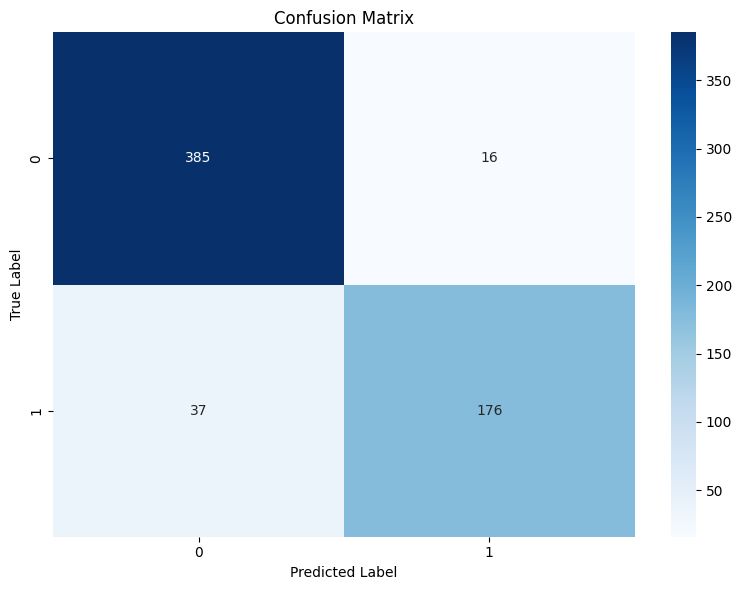

In [90]:
plot_confusion(predictions, y_train, [0,1])

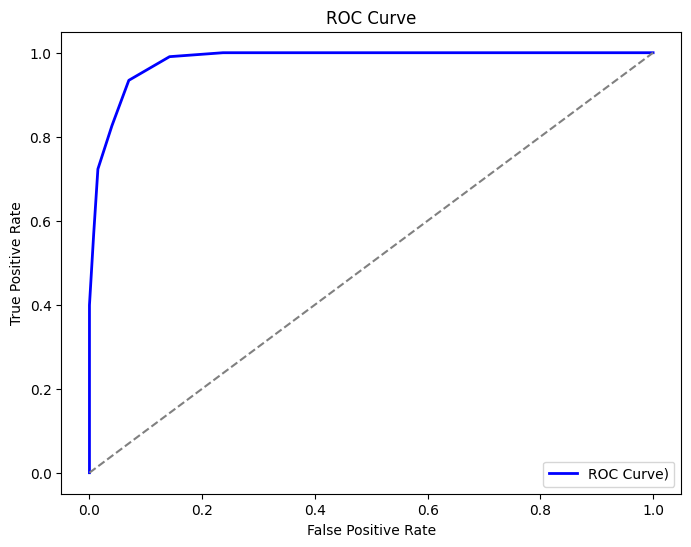

In [91]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
  y_scores = model.predict_probability(X_test)
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve)')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

# Example usage:
plot_roc_curve(rf_model, X_train, y_train)

# Submission Instructions

## Task Overview:
The goal is to train a Random Forest model using the provided training dataset and generate predictions for the `dataset_test.csv` dataset. The predictions should be saved in a file named `RollNo_P1.csv`. Additionally, you need to submit the model's predicted probabilities on `X_test` as `RollNo_test_prob.npy`. The ROC curve will be evaluated automatically.

Do **not** modify the order or any columns from the `dataset_test.csv`.

1. **Generate Predicted Probabilities**:
   - Use the model to generate the predicted probabilities for `X_test`.
   - Save these probabilities in a file named `RollNo_test_prob.npy`:
     ```python
     test_predict_probability = rf_model.predict_proba(X_test)
     np.save('RollNo_test_prob.npy', test_predict_probability)
     ```
2. **Submit Your Files**:
   - Submit both files:
     - `RollNo_P1.csv` (containing the predictions)
     - `RollNo_test_prob.npy` (containing the predicted probabilities)

### Important Notes:
- Failing to follow the naming conventions or modifying the structure of the test dataset will result in a penalty of marks.


In [92]:
df = pd.read_csv('dataset_test.csv')
X = df.iloc[:, :].values
y_pred_test = rf_model.predict(X)
y_prob_test = rf_model.predict_probability(X)
np.savetxt('22CS10065_P1.csv', y_pred_test, delimiter=',', fmt='%d')
np.save('22CS10065_test_prob.npy', y_prob_test)